In [7]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/barkh/OneDrive/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost", 
                           username = "root" ,
                           password = "1234" , 
                           database = "ecommerce")

cur = db.cursor()
                           


#  List all unique cities where customers are located.


In [4]:
query = """ select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# Count the number of orders placed in 2017.

In [18]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = '2017' """

cur.execute(query)

data = cur.fetchall()
print("Total orders places in 2017 are" , data[0][0])


Total orders places in 2017 are 45101


# Find the total sales per category.

In [30]:
query = """ select products.product_category, round(sum(payments.payment_value),2) from products 
            join order_items on products.product_id = order_items.product_id
            join payments on payments.order_id = order_items.order_id 
            group by products.product_category """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])

df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that were paid in installments.


In [50]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end) *100 )/count(order_id) from payments """

cur.execute(query)

data = cur.fetchall()
print(f"the percentage of orders that were paid in installments is {data[0][0]}")

the percentage of orders that were paid in installments is 99.9981


# Count the number of customers from each state. 

Text(0.5, 1.0, 'Customers from each state')

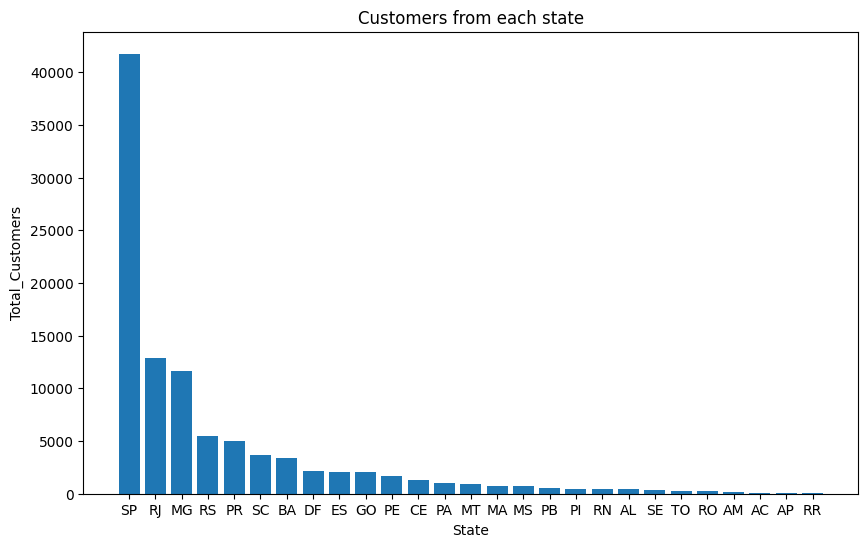

In [36]:
query = """ select customer_state,count(customer_id) from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()
# print(f"the number of customers from each state are {data}")

df = pd.DataFrame(data, columns = ['State','Total_Customers'])
df = df.sort_values(by = 'Total_Customers', ascending = False)

plt.figure(figsize=(10, 6))
plt.bar(df['State'],df['Total_Customers'])
plt.xlabel('State')
plt.ylabel('Total_Customers')
plt.title('Customers from each state')

#  Calculate the number of orders per month in 2018.

Text(0.5, 1.0, 'Count of Orders by Months is 2018')

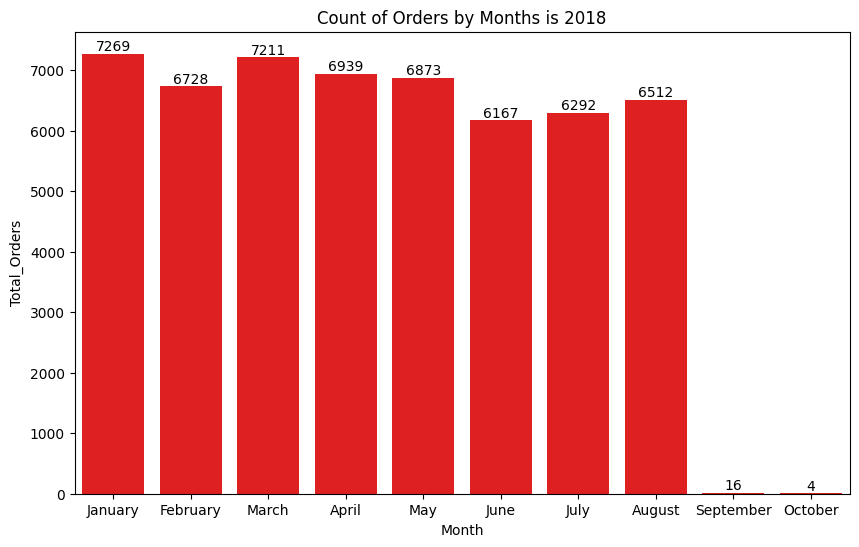

In [30]:
query = """select monthname(order_purchase_timestamp) as month,count(order_id) from orders where year(order_purchase_timestamp)  = '2018' 
            group by month,month(order_purchase_timestamp) order by month(order_purchase_timestamp)"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Month','Total_Orders'])
df
plt.figure(figsize=(10,6))
ax = sns.barplot(x = df["Month"],y =  df["Total_Orders"], data = df, color = "red")
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")           

# Find the average number of products per order, grouped by customer city.

In [45]:
query = """with count_per_order as
            (
            	select orders.order_id,orders.customer_id, count(order_items.order_id) as count from orders
            	join order_items on orders.order_id = order_items.order_id
            	group by orders.order_id,orders.customer_id
            )
            select customers.customer_city, round(avg(count),2) as average_orders from customers
            join count_per_order on customers.customer_id = count_per_order.customer_id
            group by customers.customer_city
            order by average_orders desc"""

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data, columns = ['Customer_City','Average_Order'])
df.head(10)
                

,Customer_City,Average_Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


#  Calculate the percentage of total revenue contributed by each product category.

In [10]:

query = """select upper(products.product_category),
            round((sum(payments.payment_value) * 100)/(select sum(payments.payment_value) from payments),2)
            as revenue_percent from products
            join order_items on products.product_id = order_items.product_id
            join payments on payments.order_id = order_items.order_id
            group by products.product_category
            order by revenue_percent desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Product_Category','Revnue_Percentage'])
df
                  
                

,Product_Category,Revnue_Percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [26]:
query = """select upper(products.product_category), count(order_items.order_id),round(avg(order_items.price),2) from products
            join order_items on order_items.product_id = products.product_id
            group by products.product_category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['category','order_count','price'])
arr1 = df['order_count']
arr2 = df['price']
a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][1])

the correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

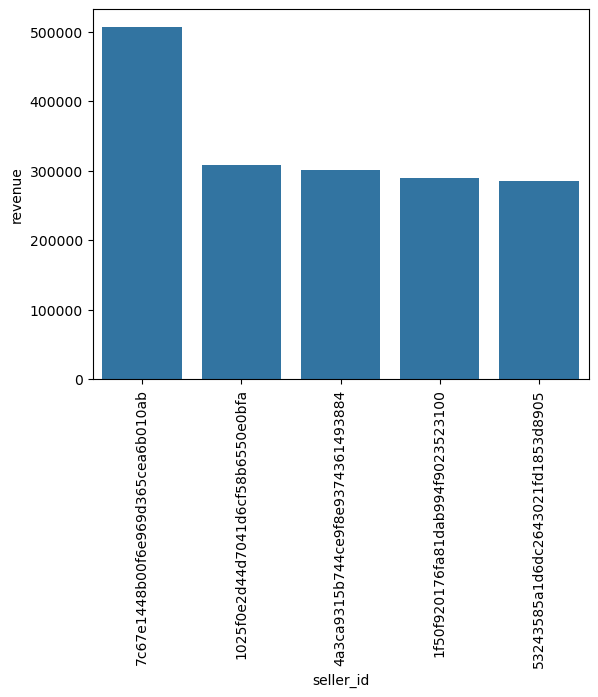

In [37]:
query = """select *, dense_rank() over(order by revenue desc) as rn from
            (select order_items.seller_id, sum(payments.payment_value) as revenue from order_items join payments
            on order_items.order_id = payments.order_id
            group by order_items.seller_id
            ) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['seller_id','revenue','rank'])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [43]:
query = """select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value,
            avg(payments.payment_value) over (partition by orders.customer_id order by orders.order_purchase_timestamp
            rows between 2 preceding and current row) as moving_avg from orders join payments on orders.order_id = payments.order_id
            group by orders.customer_id, orders.order_purchase_timestamp, payments.payment_value """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['customer','timestamp','payment','average'])
df

,customer,timestamp,payment,average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103266,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103267,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103268,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103269,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.


In [60]:
query = """select year(orders.order_purchase_timestamp), month(orders.order_purchase_timestamp),round(sum(payments.payment_value),2),
        sum(round(sum(payments.payment_value),2)) over (partition by year(orders.order_purchase_timestamp) order by month(orders.order_purchase_timestamp)
        rows between unbounded preceding and current row) as cummulative_row from orders join payments on 
        orders.order_id = payments.order_id 
        group by year(orders.order_purchase_timestamp), month(orders.order_purchase_timestamp)
        order by year(orders.order_purchase_timestamp) asc,month(orders.order_purchase_timestamp)asc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['year','month','payment','cum_sales'])
df


,year,month,payment,cum_sales
0,2016,9,756.72,756.72
1,2016,10,177271.44,178028.16
2,2016,12,58.86,178087.02
3,2017,1,415464.12,415464.12
4,2017,2,875724.03,1291188.15
5,2017,3,1349590.80,2640778.95
6,2017,4,1253364.09,3894143.04
7,2017,5,1778756.46,5672899.50
8,2017,6,1533829.14,7206728.64
9,2017,7,1777148.76,8983877.40


# Calculate the year-over-year growth rate of total sales.


In [75]:
query = """with cte as (
                select year(orders.order_purchase_timestamp) as year, 
                round(sum(payments.payment_value),2) as payment,
                lag(round(sum(payments.payment_value),2),1) over (order by year(orders.order_purchase_timestamp))
                as prev_year_sale
                from orders join payments on  orders.order_id = payments.order_id  
                group by year(orders.order_purchase_timestamp)
                
                ) 
            select *,round(((payment-prev_year_sale)*100)/prev_year_sale,2) as YoY from cte
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['year','payment','prev_year_sale','YoY'])
df


,year,payment,prev_year_sale,YoY
0,2016,178087.02,NaN,NaN
1,2017,21749240.18,178087.02,12112.7
2,2018,26099289.16,21749240.18,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [88]:
query = """with first_order_cte as 
	(
		select min(order_purchase_timestamp) as first_order, (customer_id) from orders 
		group by customer_id     
	),
  
second_order_cte as 
	(
		select orders.customer_id , min(orders.order_purchase_timestamp) as second_order from orders 
		join first_order_cte on orders.customer_id = first_order_cte.customer_id 
		where orders.order_purchase_timestamp > first_order_cte.first_order
		and (TIMESTAMPDIFF(MONTH, first_order_cte.first_order, orders.order_purchase_timestamp) <= 6)
		group by orders.customer_id
	)
    
select count(*) * 100/(select count(*) from first_order_cte) as retentention_rate_poercentage from second_order_cte
;"""
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('0.0000'),)]

# Identify the top 3 customers who spent the most money in each year.

In [113]:
query = """ with yearly_spent as 
            (
                select orders.customer_id as customers,
                year(order_purchase_timestamp) as year,
                round(sum(payments.payment_value),2) as payment from orders
                join payments on payments.order_id = orders.order_id
                group by orders.customer_id,year(order_purchase_timestamp)
                order by year(order_purchase_timestamp) asc
            )
            select customers,year,payment
            from(
                select customers, year, payment, 
                dense_rank() over(partition by year order by payment desc) as rn from yearly_spent
                ) as a
                where rn<=3"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['customer','year','payment'])
df

,customer,year,payment
0,a9dc96b027d1252bbac0a9b72d837fc6,2016,4270.65
1,1d34ed25963d5aae4cf3d7f3a4cda173,2016,4202.22
2,4a06381959b6670756de02e07b83815f,2016,3683.34
3,1617b1357756262bfa56ab541c47bc16,2017,40992.24
4,c6e2731c5b391845f6800c97401a43a9,2017,20787.93
5,3fd6777bbce08a352fddd04e4a7cc8f6,2017,20179.98
6,ec5b2ba62e574342386871631fafd3fc,2018,21824.64
7,f48d464a0baaea338cb25f816991ab1f,2018,20766.63
8,e0a2412720e9ea4f26c1ac985f6a7358,2018,14428.32
